# **ORIE 4850 Final Report: Modeling LLM-Query Serving Systems**
#### By: Darcy del Real, Alex Gardocki, Joonseok Jung, Rishi Kumar, Anurag Yadav





## **Executive Summary**

This report presents a simulation-based study of large language model (LLM) query-serving systems, with the goal of understanding how scheduling and batching policies affect latency, throughput, and scalability under realistic workloads. Motivated by the growing deployment of LLMs in latency-sensitive applications, we develop a discrete-event stochastic simulation that captures key operational characteristics of modern GPU-backed inference systems .

The system is modeled as a continuous-time queueing process in which user queries arrive according to a Poisson process. Each query is characterized by prompt lengths and stochastic output token budgets, reflecting the variability observed in real-world LLM usage. Query processing is divided into two sequential phases: a computationally intensive prefill phase, in which the prompt is processed, and a decode phase, in which output tokens are generated one at a time. GPU workers execute these tasks in batches, incurring both a fixed setup cost per batch and a marginal cost per additional token.

Using this framework, the report evaluates dual scheduling policies across different levels of parallelism. The baseline policy processes queries without batching, assigning at most one query per GPU worker at a time. Simulation results show that increasing the number of GPU workers reduces latency when the system is under-provisioned, as queueing delay dominates performance. However, beyond a moderate level of parallelism, further scaling yields little benefit: latency plateaus because each query independently pays the full per-batch setup cost during prefill. This result highlights a fundamental scalability limitation of unbatched prefill strategies, even in highly parallel systems.

To address this limitation, this report studies a chunked prefill scheduler inspired by Sarathi-Serve, which interleaves prefill and decode tokens from multiple queries within the same batch. By breaking prefill work into smaller chunks and combining it with decode tokens, this policy amortizes fixed batch costs and stabilizes batch sizes. The simulation framework is used to analyze throughput saturation points, latency distributions, and service-level objectives such as time-to-first-token (TTFT) and time-between-tokens (TBT). Results indicate that batching-based schedulers substantially improve scalability and tail latency compared to the unbatched baseline, particularly under higher load .

We validate the correctness of the simulator by comparing a simplified configuration against analytical queueing-theoretic results. In a limiting case without batching or setup costs, simulated response times closely match theoretical predictions for an M/G/1 queue — altough we also compared to an M/M/1 queue — providing statistical evidence that the event scheduling and service-time dynamics are implemented correctly.

Overall, this report demonstrates that while adding GPU resources can mitigate queueing delays, it is insufficient on its own to achieve scalable, low-latency LLM serving. Effective batching—especially during the prefill phase—is essential to improving both average and tail performance. The simulation framework developed in this work provides a flexible and validated tool for evaluating future scheduling policies and system design choices in LLM inference infrastructure.


==========================================================================================================



##**Modeling Approach**

We model the LLM query-serving system as a discrete-event stochastic simulation in continuous time, meaning events occur at random time intervals and are not restricted to discrete time intervals. Queries from users arrive according to a Poisson process with rate $λ$. We ran simulations with a variety of values for $\lambda$ in order to determine what arrival rate would saturate the system. Based on these results, we chose to set $\lambda = 1 \ \mathrm{query/s}$ to prevent saturating the system. See the appendix for more details.

Each query $i$ is characterized by two features:

* $L_i$: The number of tokens in the prompt
* $B_i$: The token budget for the LLM's response

Both the prompt length and token budget are randomly distributed for each query. The prompt length uses a mixture of short (64 tokens), medium (256 tokens), and long (512 tokens) prompts, with each length being having equal probability. This large range of prompt lengths is an important characteristic of actual LLM queries which a query-serving system needs to account for. The token budget is geometrically distributed with parameter $p = 0.1$ and a fixed upper bound of $32$ tokens. This captures the fact that with each generated token, there is a chance the LLM will reach a stopping point for its response.

Queries are processed in two sequential phases:

* **Prefill**: The model processes the prompt and prepares to emit the first token. This is computationally intensive. The entire prompt must be prefilled before moving on to the decode phase.
* **Decode**: The model generates the response one token at a time. Each token is processed quickly, but the previous token must finish processing before starting the next.

Processing is handled by GPU workers, which are capable of processing multiple queries at once in a single batch. Each GPU worker has a maximum batch size $K$, which is the maximum number of tokens a GPU worker can process in a single batch. We chose $K = 512$ to match the maximum prompt length so that the entire prefill phase of a query can be processed on a single GPU worker. Based on a paper by [Li et al.](https://arxiv.org/abs/2504.07347), processing a batch requires a fixed setup time $C$ as well as a marginal cost per token $A$ for tokens beyond a minimum batch threshold $b_0$. The following equation summarizes the processing time required for a batch of $b$ tokens:
$$S(b) = C + A \cdot \max(0, b - b_0)$$
In order to account for random variations in computation time, our simulation models $C$ and $A$ as exponentially distributed random variables. We used $c = 45.5 \mathrm{ms}$ as the mean for $C$, $a = 0.30 \mathrm{ms/token}$ as the mean for $A$, and $b_0 = 64 \ \mathrm{tokens}$ based on the results of [Li et al.](https://arxiv.org/abs/2504.07347)

In order to determine which prefill and decode tasks should be processed in each batch, a scheduler assigns and distributes tasks among the GPU workers and decides when each idle worker should start a new batch. See the **Scheduler Details** section for more information on how the basic scheduler and chunked scheduler prioritize tasks.

---
### **Model Parameters**

The following parameters fully define the behavior of the baseline LLM-serving system:

\
\begin{array}{ll}
\lambda & \text{average arrival rate (queries per second)} \\[6pt]
L_{min} & \text{minimum prompt length (tokens)} \\[6pt]
L_{max} & \text{maximum prompt length (tokens)} \\[6pt]
p & \text{geometric distribution parameter for output budget } \\[6pt]
B_{max} & \text{maximum output budget (tokens)} \\[6pt]
K & \text{maximum batch size (tokens)} \\[6pt]
b_0 & \text{minimum batch size threshold (tokens)} \\[6pt]
a & \text{average marginal cost per token beyond } b_0 \text{ (ms/token)} \\[6pt]
c & \text{average fixed cost per batch (ms)} \\[6pt]
\end{array}

---
### **Performance Metrics**

In order to evaluate the performance of the system, we record key latency and utilization metrics throughout the simulation. The most obvious metric is **Throughput**, measured in queries per second. We also track latency through the use of two Service-Level Objects (SLOs):

* **Time To First Token (TTFT)**: The total time until the prefill phase has finished and the system can start processing the first output token.
* **Time Between Tokens (TBT)**: The average time taken between each successive output token for a given query.

Latency is evaluated based on both the mean latency and the *tail latency*, which we define as the 95th percentile of queries with the highest latency.

## **Model Details**

The LLM-serving system is implemented using a discrete-event simulation framework that explicitly models query lifecycles, GPU batch execution, and scheduler decisions. The simulator maintains a dynamic state consisting of:

* A queue of waiting queries,
* A list of active GPU worker batches being processed,
* Remaining prefill/decode tokens for each active query,
* Service statistics for each processed query, and
* An event calendar listing upcoming events.

The diagram below shows each component of the simulator's state.

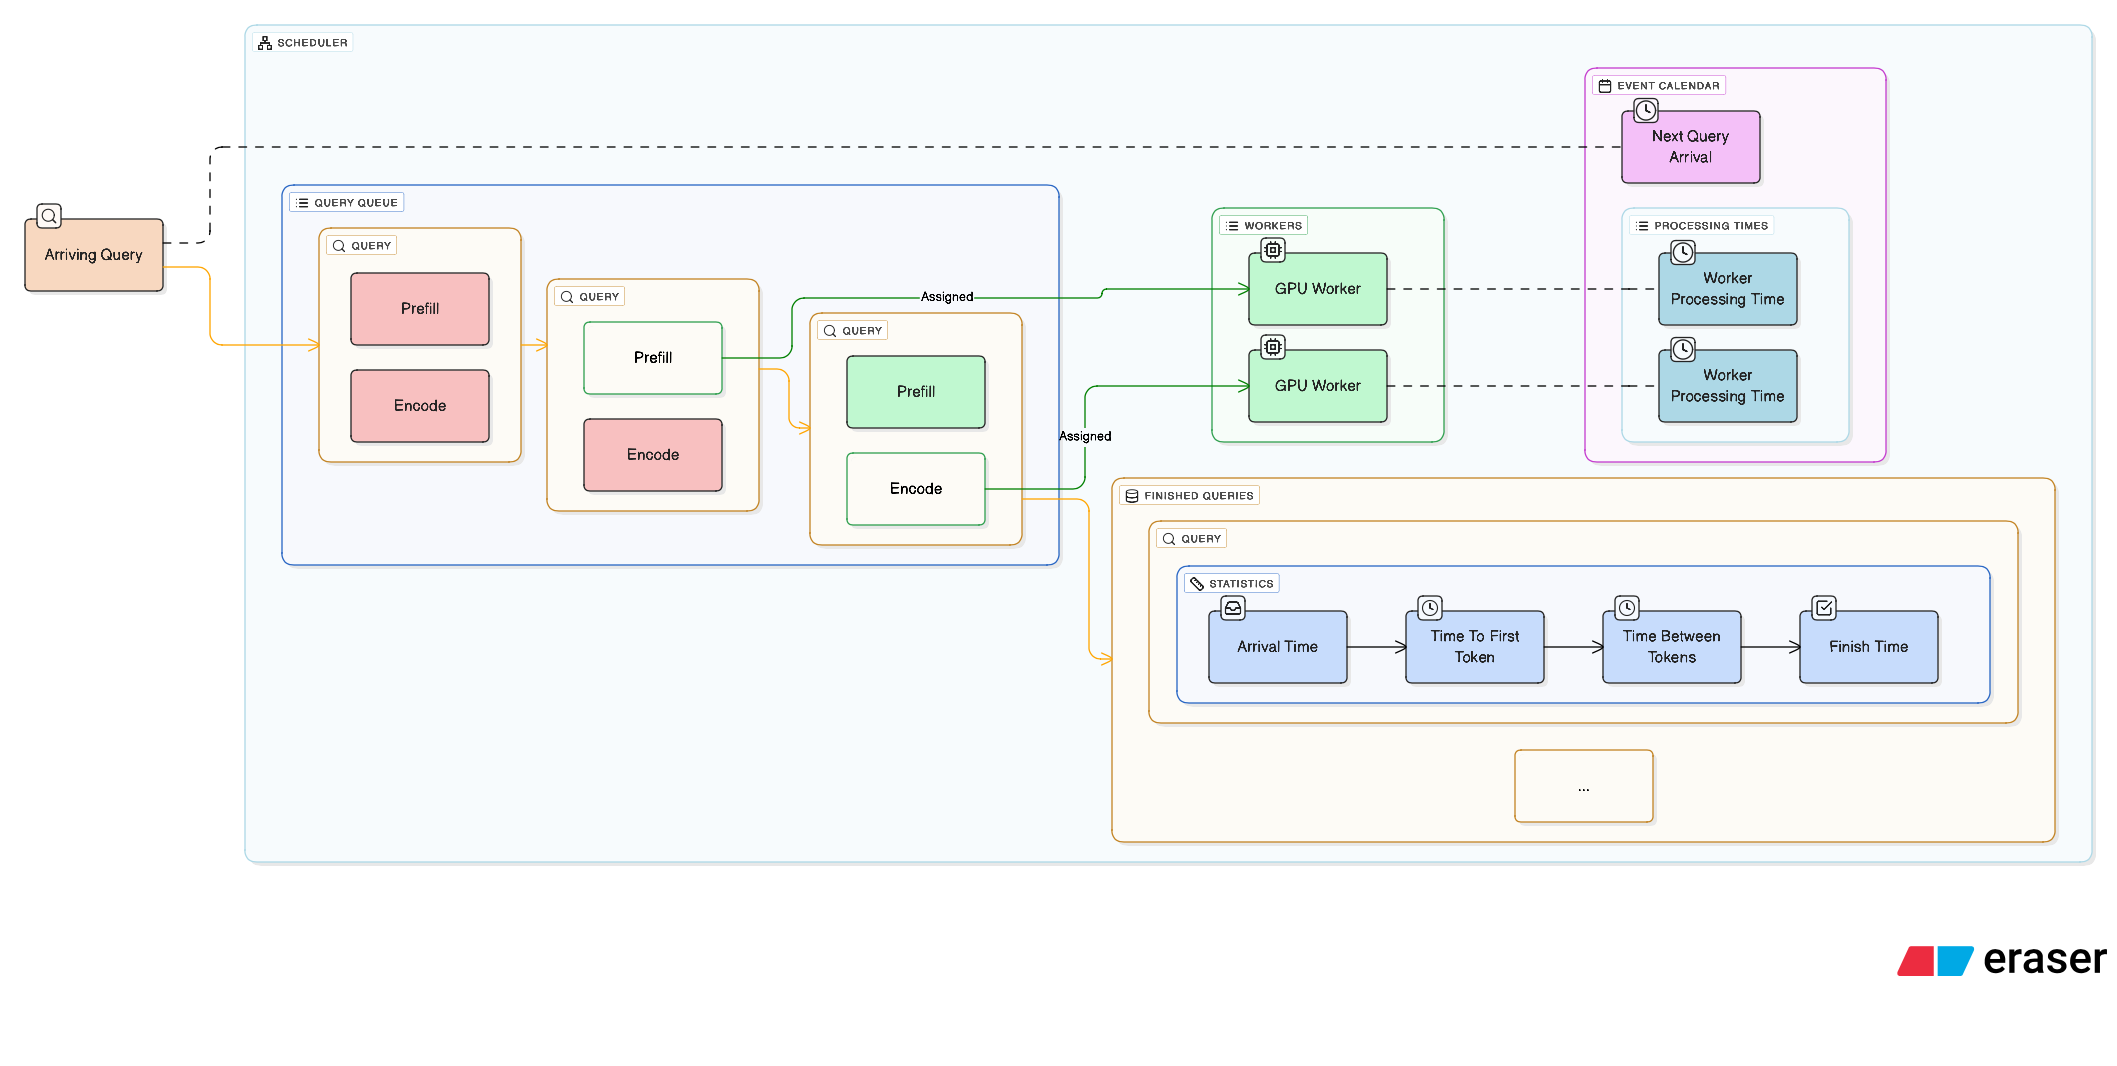

The event calendar is used to schedule future events and advance the system clock. The calendar contains both the time when the next query will arrive and the time when each actively processing GPU worker will finish processing. At each simulation iteration, the clock is advanced to the next earliest event, triggering one of the following state transitions:

1. **Query Arrival**: A new query enters the input queue. If there are any idle GPU workers, the scheduler determines which jobs from this query to assign to each worker.
2. **Batch Completion**: A GPU worker finishes processing a batch of tokens. The state for each query that was being processed is updated accordingly, and any finished queries are removed from the queue and added to the finished queries list. The scheduler then assigns jobs from any pending queries to the now idle GPU worker.

When the simulation is finished running, performance metrics can be extracted from the list of finished queries since each query stores its own arrival time, finish time, and SLOs. We utilized replication-deletion sampling in order to generate confidence intervals for each measurement, discarding the first $2000$ completed queries for each trial to eliminate the effects of the warmup period. Each replication was run until at least $10000$ queries were generated to ensure stability.

---
## **Scheduler Details**

### **Scheduler 1: Traditional Prefill (Unchunked) Policy**

Scheduler 1 is a baseline unbatched system. Each GPU worker processes at most one query at a time. Prefill is performed for the entire remaining prompt of a query in a single batch, and decoding proceeds token-by-token, with each decode token processed as its own batch. No batching is performed across queries in either phase.



### **Scheduler 2: Sarathi-Serve Policy**

Scheduler 2 is a Sarathi-Serve scheduler, as described by [Agrawal et al.](https://arxiv.org/abs/2403.02310) Rather than processing each prefill phase in a single batch, prefill phases are broken into chunks which can be distributed between multiple GPU workers. In our basic scheduler, each worker is either processing a single decode token or a full prefill phase. This leads to large amounts of wasted compute during the decode phase due to the fixed cost of running a batch. The Sarathi-Serve scheduler allows for hybrid batches which contain both decode and prefill tokens. By breaking the prefill phase into smaller chunks, the Sarathi-Serve scheduler can achieve roughly the same number of tokens for all batches. This amortizes the fixed cost of running a batch and reduces the variance in Time Between Tokens.

The diagram below summarizes the scheduling process. Queries in the decode phase are prioritized and assigned to GPU workers first. Then, a chunk of the prefill phase for each query that has started the prefill phase is assigned. Finally, if the workers have remaining space in their batches, prefill chunks from new queries are added.

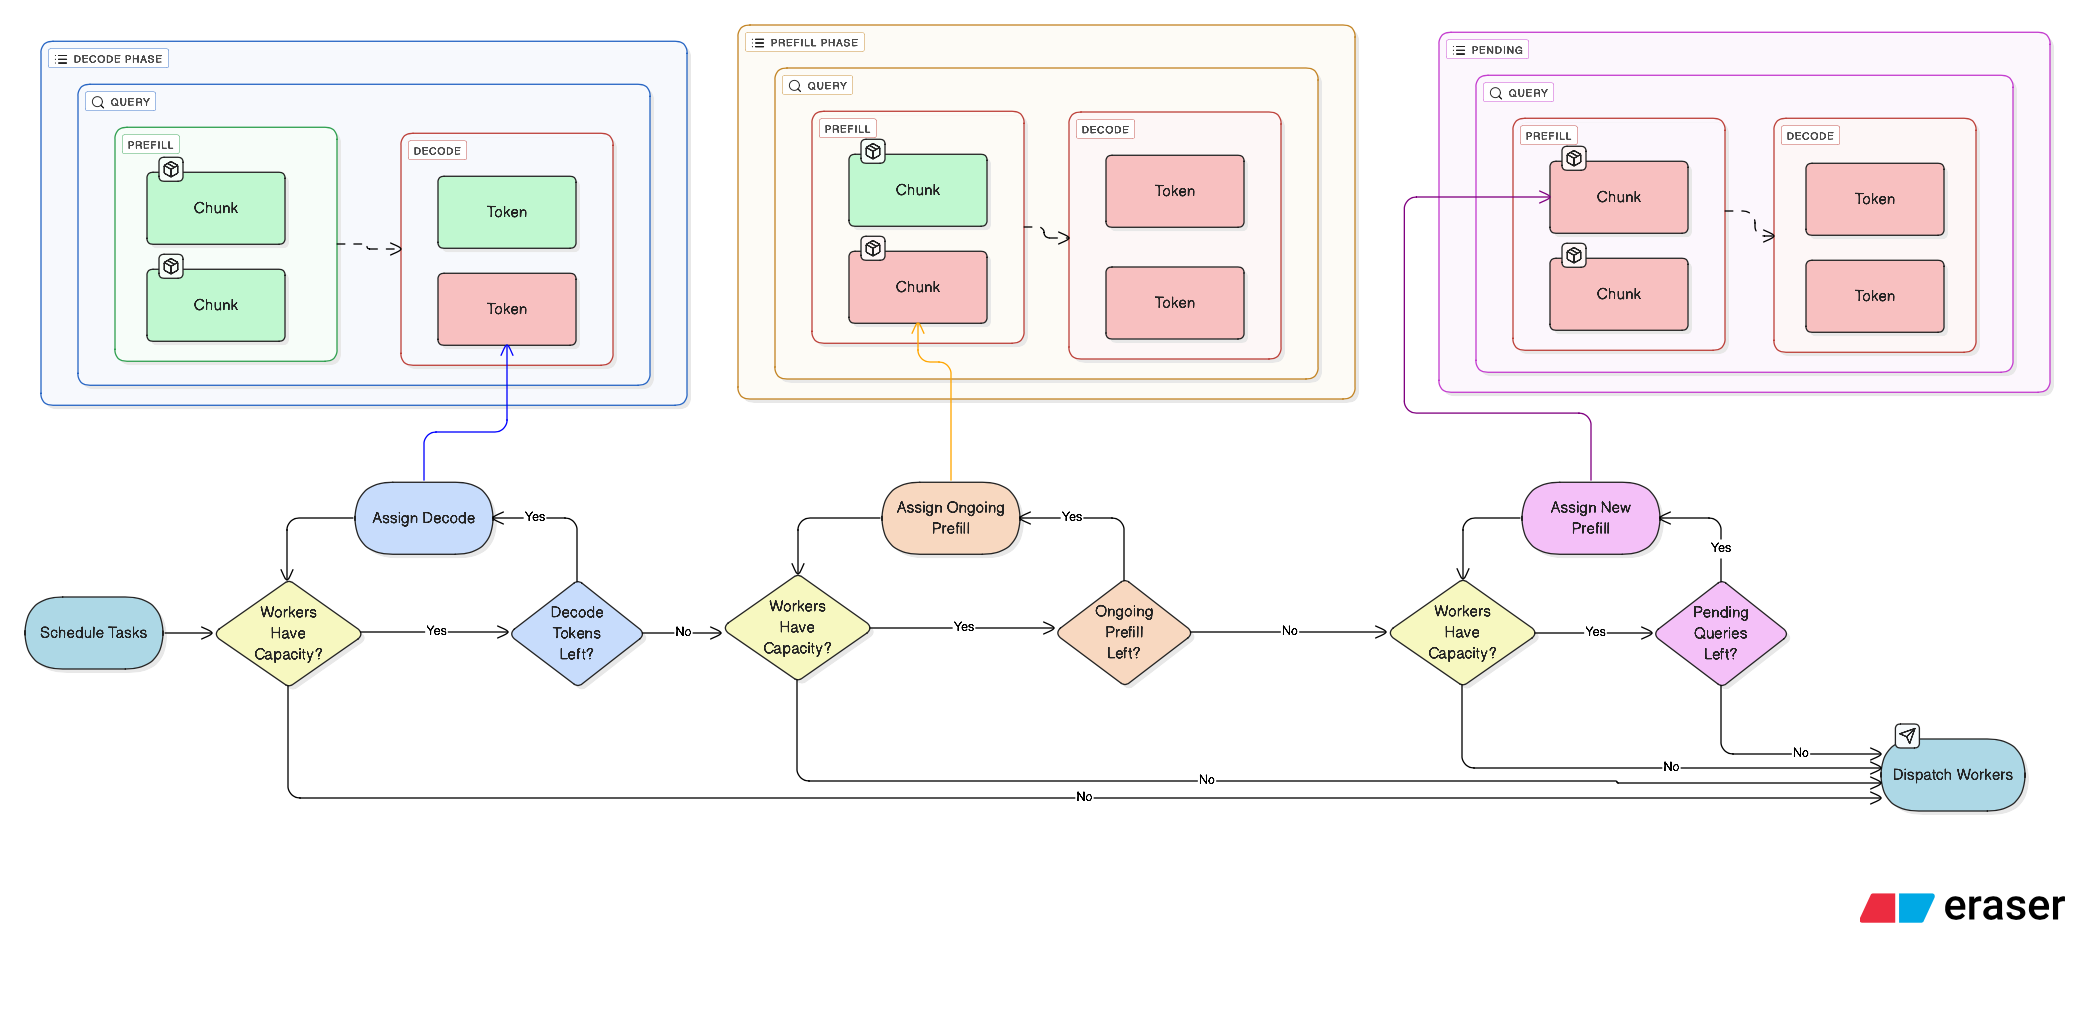

Because one of the major advantages of the Sarathi-Serve scheduler is its ability to keep batch sizes consistent, we decided to lower the maximum batch size to $K = 128$ for this scheduler. This reduced latency from excessively large batches at the cost of reduced throughput. We chose $K = 128$ since this is still large enough to fit the entirety of a small prompt prefill phase on a single GPU worker, but small enough that larger prompts will require chunking and multiple iterations.

# **Model analysis**

## Throughput

We began our analysis by determining the maximum throughput for each of the schedulers. One of the major benefits of amortizing set up costs through chunking is increasing the overall throughput. Hence, we expect Scheduler 2 to outperform Scheduler 1. To evaluate their performances, we tested them both using a single GPU worker and a variety of choices for $\lambda$, the query arrival rate. By plotting the throughput of the system vs the query arrival rate, we were able to determine at what point the system became saturated.

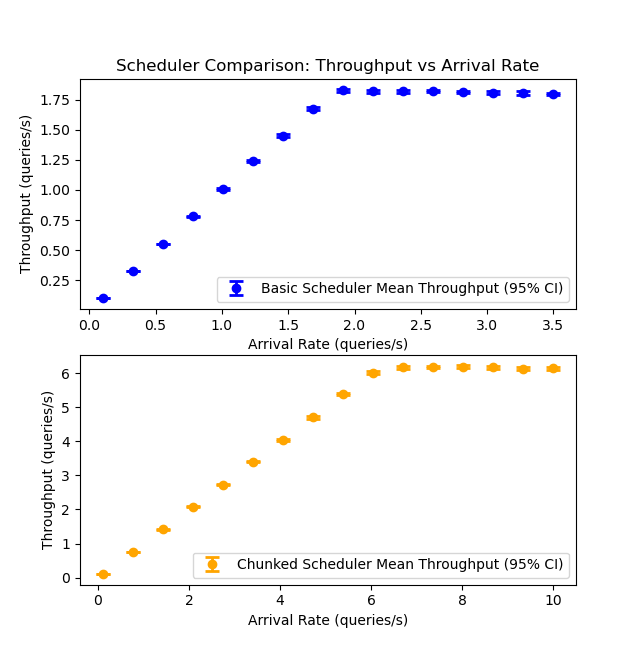

Both graphs show a clear "elbow" where increasing the number of incoming queries no longer increases the rate at which queries are completed. For the basic scheduler, this is near $2$ queries/s, while Scheduler 2 is able to support nearly triple this rate. This demonstrates the efficiency gain provided by chunking and proper batching of tasks.

### Parallelism

One question we wanted to consider was whether we could make up for the performance gains from proper batching by simply using more compute power with our naive scheduler. For this reason, we simulated both Scheduler 1 and Scheduler 2 with 1, 10, and 100 GPU workers and a query arrival rate of $\lambda = 1$ query per second.

###**Scheduler 1: Traditional Prefill (Un-Chunked) for 1, 10, 100 Workers**


#### **What We Test**

With our first scheduler, we wanted to evaluate the effect of parallelism under an unchunked prefill policy. We varied the number of available GPU workers—1, 10, and 100—while keeping workload and service-time parameters fixed. This isolates the impact of queueing and system capacity in the absence of batching.

---

#### **Simulation Results**

Across 10 independent replications, we observe the following average behavior:

- **1 worker:** mean TTFT ≈ **628 ms**, mean End-To-End ≈ **1068 ms**  
- **10 workers:** mean TTFT ≈ **108 ms**, mean End-To-End ≈ **547 ms**  
- **100 workers:** mean TTFT ≈ **108 ms**, mean End-To-End ≈ **547 ms**

The average time-between-tokens (TBT) is approximately **45 ms/token** for all configurations, with very small variance across replications.

---

#### **Analysis and Interpretation**

The overall throughput in all cases is very close to $1$ query/second since the system is far from saturated, so the arrival rate determines the throughput.

Increasing the number of workers from 1 to 10 leads to a dramatic reduction in both TTFT and end-to-end latency. This improvement is driven by the elimination of queueing delay: with sufficient parallelism, arriving queries are assigned to idle workers almost immediately, and latency becomes dominated by intrinsic service time rather than waiting time.

However, increasing the number of workers further from 10 to 100 yields almost no additional improvement. Once queueing delay is negligible, latency is bounded by per-query service requirements. Because prefill is unchunked, each query independently incurs the full setup cost and marginal per-token cost, preventing further scalability gains.

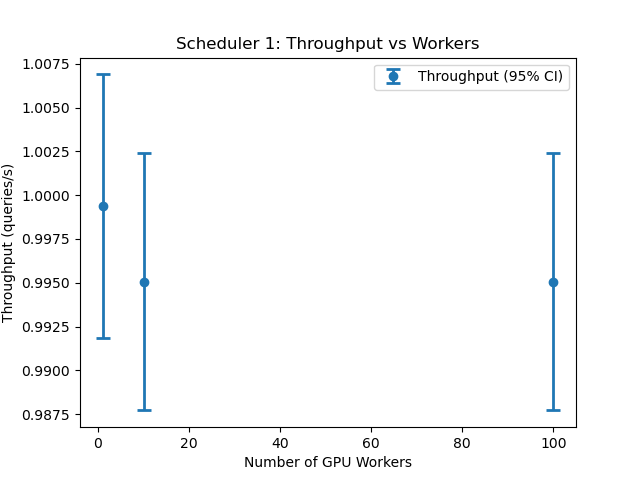

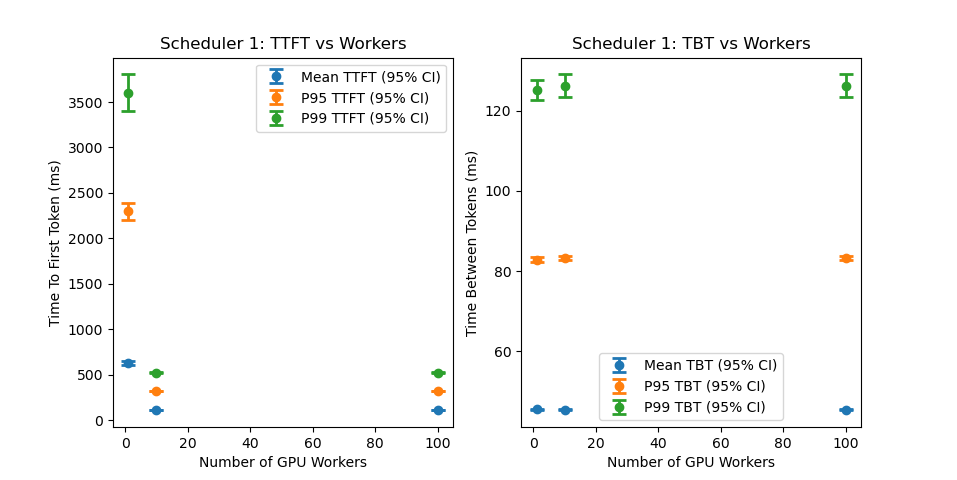

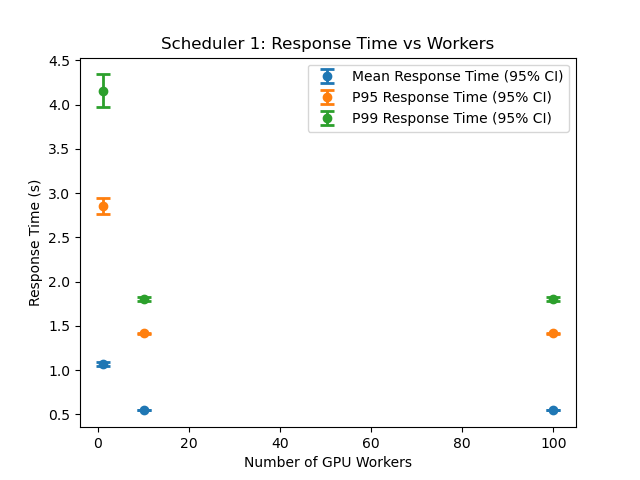

---

#### **Time Between Tokens**

It is notable that both the mean and tail Time Between Tokens remains nearly unchanged as the number of GPU workers changes. This is a direct result of the model's inability to perform more than one decode task at a time. In Scheduler 1, each decode batch processes exactly one token $b=1$. Since $1 < b_0$, we have $max(0, b - b_0) = 0$, so the batch service time reduces to the setup cost $C$. Since $E[C] = c = 45.5$ ms, the observed average TBT closely matches the theoretical expectation.

---

### **Recommendations**

Scheduler 1 demonstrates that simply increasing the number of GPU workers is insufficient to achieve scalable performance when prefill is unbatched. While adding workers reduces queueing delay under light to moderate load, intrinsic per-query setup costs dominate latency once contention is removed. To achieve further improvements in throughput and tail latency, batching-based scheduling strategies—particularly for prefill—are necessary. This motivates the more sophisticated scheduling policies explored in subsequent models.

##**Scheduler 2: Sarathi-Serve for 1, 10, 100 Workers**

In contrast with Scheduler 1, Scheduler 2 demonstrates the power of amortizing costs and chunking the the prefill phase into smaller pieces that can be evenly distributed amongst GPU workers. For the purpose of comparison we utilized the same parameters that we used with Scheduler 1 to generate simulation data using the Sarathi-Serve scheduler. The one change we made was reducing the maximum batch size, since a scheduler can always choose to not use the full size of a batch, and the extremely large batch size was a necessary requirement for the naive scheduler.

---

### **Simulation Results**

Across 10 independent replications, we observe the following average behavior:

- **1 worker:** mean TTFT ≈ **369 ms**, mean End-To-End ≈ **811 ms**  
- **10 workers:** mean TTFT ≈ **85 ms**, mean End-To-End ≈ **524 ms**  
- **100 workers:** mean TTFT ≈ **85 ms**, mean End-To-End ≈ **523 ms**

Interestingly, the average time-between-tokens (TBT) was again approximately **45 ms/token** for all configurations.

### Analysis and Interpretation

Comparing with Scheduler 1, it is immediately obvious that Scheduler 2 has far lower latency when there is only one GPU worker available. This is indicative of Scheduler 2's ability to more efficiently leverage resources, especially in the decode phase where the fixed cost of running a batch is balanced between multiple queries instead of blocking other queries from starting. Despite this stronger leveraging of resources, the performance gains still quickly drop off at 100 GPU workers, likely because there simply are not enough tasks to divide amongst them to provide any noticeable improvement in speed.


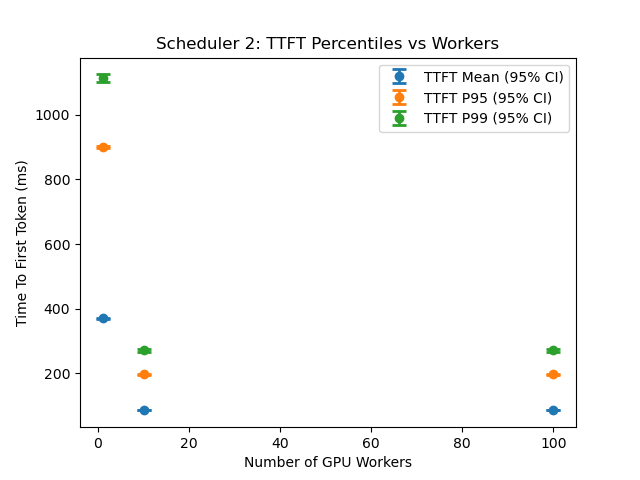

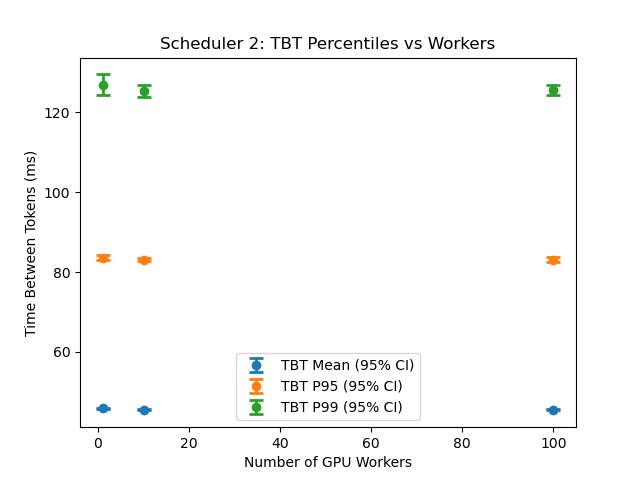

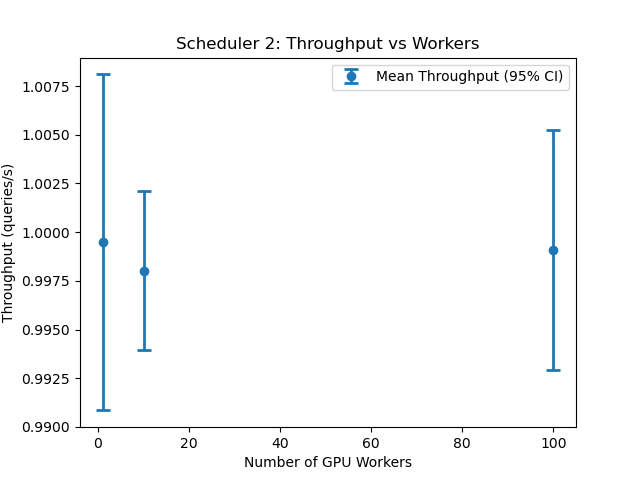

### **Time Between Tokens**

Interestingly, the Time Between Tokens again appears to be remarkably consistent across different numbers of GPU workers. This is surprising since the extra prefill chunks that get batched together with the decode tokens should cause the time between tokens to increase while reducing its variability. For the trials with the larger numbers of GPU workers, it is possible that queries arrivals were sparse enough that tasks could be spread between GPU workers at a level below the minimum batch threshold $b_0$, but this does not explain the behavior for the single GPU worker case. Further research into this phenomenon is necessary.

### **Recommendations**

While the Sarathi-Serve scheduler shows a notable improvement over the naive scheduler in operation with a single GPU, the performance gains quickly fade as the system becomes too large for the chosen arrival rate. This underutilizes the immense power of the Sarathi-Serve scheduler, which can be seen in its ability to triple throughput as shown above. This scheduler would perform better in a higher load environment where it could take full advantage of its efficient allocations of tasks between batches.

#**Conclusion**

Across all experiments, a consistent structural result emerges: **parallelism alone is insufficient to deliver scalable, low-latency LLM serving when prefill is unbatched**. While increasing the number of GPU workers dramatically reduces queueing delay in under-provisioned systems, latency quickly plateaus once contention is removed. At that point, intrinsic per-query costs — most notably the fixed batch setup cost incurred during prefill — dominate both mean and tail latency. Simulation results for the unbatched scheduler clearly demonstrate diminishing returns when scaling from 10 to 100 workers, despite abundant compute capacity.

In contrast, **batching-based schedulers fundamentally change the scalability profile of the system**. The chunked prefill (Sarathi-Serve–style) scheduler amortizes fixed batch costs by interleaving prefill and decode tokens across queries and stabilizing batch sizes. This leads to substantial improvements in throughput saturation points, time-to-first-token (TTFT), and tail latency, particularly under higher load. Importantly, these gains arise not from additional hardware, but from more efficient utilization of existing GPU resources through scheduling design.

The correctness of the simulation framework is supported by both analytical and empirical validation. In a simplified limiting regime without batching or setup costs, simulated steady-state response times closely match M/G/1 queueing-theoretic predictions, confirming that event scheduling and service-time dynamics are implemented correctly. For the chunked scheduler—where classical queueing analysis does not apply—limiting-case consistency checks and sensitivity analyses show smooth convergence to baseline behavior and stable performance across a wide range of chunk sizes .

Overall, this work demonstrates that **effective batching, particularly during the prefill phase, is a first-order design requirement for scalable LLM inference systems**. Merely adding GPUs can alleviate queueing delay but cannot overcome fixed per-batch costs that dominate latency at scale. The simulation framework presented here provides a flexible, validated platform for exploring future scheduling policies, hardware configurations, and workloads, and can be readily extended to study priority scheduling and multi-model serving scenarios in production LLM infrastructure.

#**Technical Appendices**






### Validation via Queueing Theory (M/G/1)

To validate the correctness of our discrete-event simulation, we compare its behavior against a simplified regime where analytical results from queueing theory are available. We restrict the system to a single GPU worker with Poisson query arrivals at rate $\lambda$, no batching, and no setup cost ($c = 0$). This configuration allows a direct comparison between simulated steady-state response times and theoretical predictions.

Each query is fixed to require exactly one prefill token and one decode token. Each token has an exponential service time with mean $a$. While arrivals are Poisson and individual service stages are memoryless, each query undergoes two sequential service stages (prefill followed by decode). As a result, the total service time per query is the sum of two independent exponential random variables:
$$
S = X_1 + X_2, \qquad X_1, X_2 \sim \mathrm{Exp}(\text{mean}=a),
$$
so $S$ follows an Erlang-2 distribution. In particular,
$$
\mathbb{E}[S] = 2a, \qquad \mathbb{E}[S^2] = 6a^2.
$$

Consequently, the system is more precisely modeled as an $M/G/1$ queue rather than an $M/M/1$ queue. Using an effective service rate $\mu = \frac{1}{2a}$ yields an $M/M/1$ approximation that is useful for intuition but does not capture the exact service-time distribution implemented by the simulator.

For an $M/G/1$ queue, the mean response time is given by the Pollaczek–Khinchine formula:
$$
\mathbb{E}[T]
= \mathbb{E}[S]
+ \frac{\lambda \, \mathbb{E}[S^2]}{2(1-\rho)},
\qquad
\rho = \lambda \, \mathbb{E}[S].
$$
We estimate the steady-state mean response time via replication–deletion simulation, discarding an initial warm-up period of 2000 events to remove transient effects, and construct a 95\% confidence interval for the simulated mean. The $M/M/1$ approximation differs from the simulated mean by approximately 15\%, indicating it is not a good approximation of the Erlang-2 service time. However, the theoretical $M/G/1$ mean response time lies within the confidence interval, providing statistical evidence that the simulator's steady-state behavior is consistent with the correct analytical model for the implemented two-stage service process. Overall, this validation demonstrates that the simulator correctly implements the intended event scheduling and service-time dynamics.



In [ ]:
import simulation as sim
import numpy as np
from math import sqrt
from scipy.stats import t

def mg1_single_replication(
    lmbda,
    a,
    num_events=100_000,
    warmup_completed=2000,
    seed=0
):
    """
    Simulate a single replication of the M/G/1 queue scheduler
    """
    np.random.seed(seed)

    # M/G/1 configuration
    sched = sim.Scheduler(
        num_workers=1,
        mean_marginal_cost=a,
        mean_fixed_cost=0.0,     # no setup cost
        min_batch_threshold=0,   # no batching effect
        max_batch_size=1,        # force single-token batches
        query_arrival_rate=lmbda,
        set_tokens=True          # Query(1,1)
    )

    # Start arrivals
    sched._handle_query_arrival()

    for _ in range(num_events):
        sched.simulate_event()

    completed = sched.completed_queries[warmup_completed:]

    response_times = [q.finish_time - q.arrival_time for q in completed]

    return np.mean(response_times)

def mg1_mean_response_time(lmbda, a):
    """
    Calculate the expected response time from the M/G/1 queue
    """
    ES = 2 * a
    ES2 = 6 * (a**2)
    rho = lmbda * ES
    if rho >= 1:
        raise ValueError("System unstable: rho >= 1")
    return ES + (lmbda * ES2) / (2 * (1 - rho))

def mm1_mean_response_time(lmbda, a):
    """
    Calculate the expected response time from the M/M/1 approximation
    """
    mu = 1 / (2 * a)
    return 1 / (mu - lmbda)

In [ ]:
import matplotlib.pyplot as plt

# Parameters
a = 0.3
lmbda = 1.0

replications = 100
means = np.zeros(replications)
for r in range(replications):
    means[r] = mg1_single_replication(lmbda, a, seed=r)

sample_mean = np.mean(means)
sample_std = np.std(means, ddof=1)

alpha = 0.05
t_crit = t.ppf(1 - alpha/2, df=replications-1)

half_width = t_crit * sample_std / sqrt(replications)

ci_lower = sample_mean - half_width
ci_upper = sample_mean + half_width

mm1_theory = mm1_mean_response_time(lmbda, a)
mg1_theory = mg1_mean_response_time(lmbda, a)

print(f"Simulated Response Time CI: [{ci_lower}, {ci_upper}]")
print(f"Approximated M/M/1 Response Time: {mm1_theory}")
print(f"Theoretical G/G/1 Response Time: {mg1_theory}")

plt.figure(figsize=(6,4))

# Plot CI as vertical line
plt.plot([1, 1], [ci_lower, ci_upper], linewidth=4, label="95% CI (Simulation)")

# Plot simulated mean
plt.scatter(1, sample_mean, zorder=3, label="Simulated Mean")

# Plot theoretical M/G/1 value
plt.scatter(1, mg1_theory, marker="x", s=80, label="M/G/1 Theory")

plt.xlim(0.9, 1.1)
plt.ylabel("Mean Response Time")
plt.xticks([])
plt.title("M/G/1 Validation of Simulator")
plt.legend()
plt.grid(True)

plt.show()


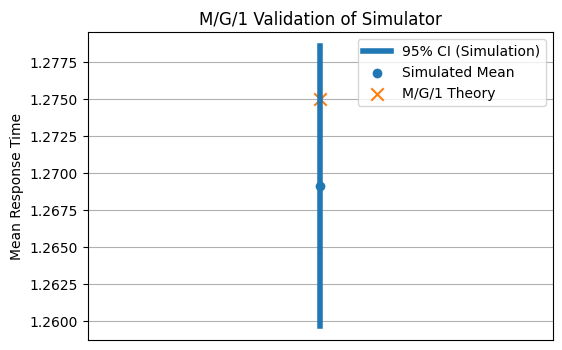

The above figure shows mean response time from replication-deletion simulation with 95% confidence interval, compared to the theoretical M/G/1 prediction. The theoretical value lies within the confidence interval, validating the simulator's steady-state behavior.

### Steady State Considerations

All of our measurements and metrics for our simulation were gathered and validated using replicaton-deletion sampling, in which the initial metrics gathered from a stochastic system on startup are discarded in order to reduce the bias introduced by the starting configuraton. Replication-deletion sampling provides a methodology for obtaining confidence intervals for metrics of infinite horizon models. However, in order to apply it successfully, the "warmup period" of the system must be evaluated to determine how many samples must be deleted before gathering usable data. We utilized running averages of each of our SLOs to confirm that our warmup period lasted less than 2000 queries for each simulation. Example figures are shown below.

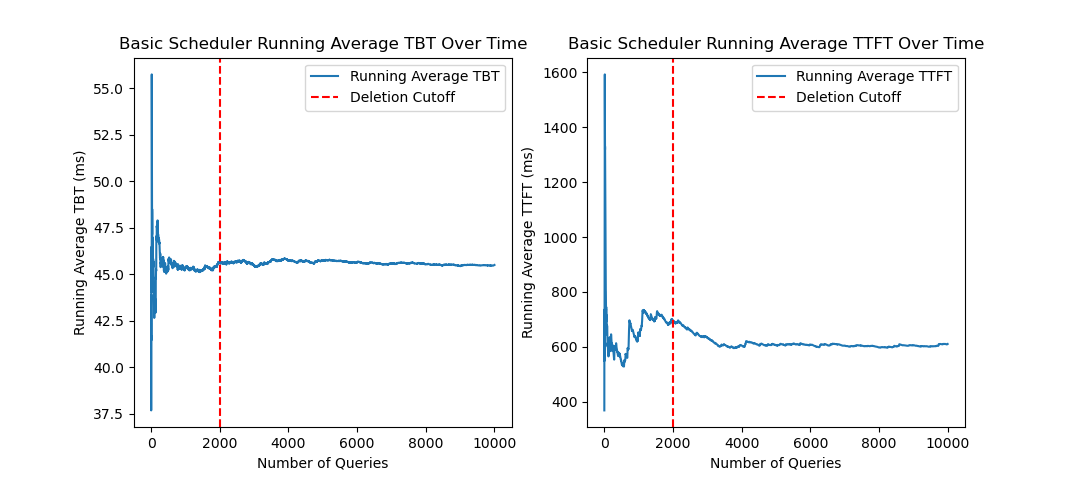

The graphs show running averages for the Time Between Tokens and Time To First Token. The graphs indicate that our choice to remove all metrics from queries before the 2000th completed query is valid and accurately accounts for the effects of the warmup period.

### Generating Visualizations

Since our simulation outputs raw service level statistics from processed queries orgaanized into a CSV, we have to do some post-processing in order to organize the data and aggregate it as needed. The following code was used by our team for this purpose.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ==================== LOAD DATA ====================
BASIC_FILE = "basic_scheduler_metrics.csv"
CHUNKED_FILE = "chunked_scheduler_metrics.csv"

basic_raw = pd.read_csv(BASIC_FILE)
chunked_raw = pd.read_csv(CHUNKED_FILE)
# ==================== REMOVE WARMUP PERIOD ====================
def remove_warmup(df, warmup_count=2000):
    """
    Remove first warmup_count queries from each replication.
    """
    filtered = []
    for rep in df['replication'].unique():
        rep_data = df[df['replication'] == rep].sort_values('arrival_time')
        # Keep queries after warmup period
        if len(rep_data) > warmup_count:
            filtered.append(rep_data.iloc[warmup_count:])
    return pd.concat(filtered, ignore_index=True)

basic = remove_warmup(basic_raw)
chunked = remove_warmup(chunked_raw)

# Add response time
basic["response_time"] = basic["finish_time"] - basic["arrival_time"]
chunked["response_time"] = chunked["finish_time"] - chunked["arrival_time"]

# ==================== CONFIDENCE INTERVAL FUNCTIONS ====================

def compute_replication_stats(df, metric, aggregate='mean'):
    """
    Compute per-replication statistics for a metric using the given aggregation method.
    """
    stats_per_rep = []
    for rep in df['replication'].unique():
        rep_data = df[df['replication'] == rep][metric]
        if aggregate == 'mean':
            stats_per_rep.append(rep_data.mean())
        elif aggregate == 'p95':
            stats_per_rep.append(rep_data.quantile(0.95))
        else:
            stats_per_rep.append(rep_data.quantile(0.99))

    return stats_per_rep

def compute_throughput_per_replication(df):
    """
    Compute throughput for each replication.
    """
    throughput_per_rep = []
    for rep in df['replication'].unique():
        rep_data = df[df['replication'] == rep]
        if len(rep_data) > 0:
            min_time = rep_data['arrival_time'].min()
            max_time = rep_data['finish_time'].max()
            duration_sec = (max_time - min_time) / 1000
            if duration_sec > 0:
                tp = len(rep_data) / duration_sec
                throughput_per_rep.append(tp)
    return throughput_per_rep

def graph_stat(df, parameter, aggregator, label, ax, color):
    """
    Graph a statistic defined by the aggregator against parameter, including CIs
    """
    data = []
    for param in df[parameter].unique():
        stats_per_rep = aggregator(df[df[parameter] == param])
        reps = len(stats_per_rep)

        mean = np.mean(stats_per_rep)

        sample_std = np.std(stats_per_rep, ddof=1)
        alpha = 0.05
        t_crit = stats.t.ppf(1 - alpha/2, df=reps-1)
        half_width = t_crit * sample_std / np.sqrt(reps)

        data.append({
            'X': param,
            'Y': mean,
            'err': half_width
        })
    df = pd.DataFrame(data)

    ax.errorbar(df['X'], df['Y'], yerr=df['err'], fmt='o', elinewidth=2, capsize=5, capthick=2, label=label, color=color)

def graph_running_avg(values, ax, label):
    """
    Graph the running average of values over time
    """
    cumulative_sum = np.cumsum(values)

    # Calculate the running average
    num_queries = np.arange(1, len(values) + 1)
    running_avg_tbt = cumulative_sum / num_queries

    # Plot the running average
    ax.plot(num_queries, running_avg_tbt, label=label)